# Import e funzioni comuni

In [ ]:
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from scipy import sparse
from ipywidgets import interact, interactive, fixed, interact_manual
from google.colab import files
import pickle

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
def evaluate_stationary_prob_vector_1(transition_matrix):
  """
  Calcola il vettore stazionario delle probabilità tramite formula
  """
  A = np.append(np.transpose(transition_matrix)- np.identity(transition_matrix.shape[0]),[np.ones(transition_matrix.shape[0])],axis=0)
  b = np.transpose(np.zeros(transition_matrix.shape[0] + 1))
  b[-1] = 1
  pi_vector_teorico = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

  return pi_vector_teorico


def evaluate_stationary_prob_vector_2(transition_matrix, n_iterations = 50):
  """
  Calcola il vettore stazionario delle probabilità tramite processo iterativo
  """
  
  state = np.zeros(transition_matrix.shape[0])
  state[0] = 1

  tmp_matrix = np.dot(transition_matrix, transition_matrix)
  tmp_matrix_2 = np.dot(tmp_matrix, tmp_matrix)
  tmp_matrix_3 = np.dot(tmp_matrix_2, tmp_matrix_2)
  tmp_matrix_4 = np.dot(tmp_matrix_3, tmp_matrix_3)

  for x in range(n_iterations):
    state = np.dot(state, tmp_matrix_4)

  pi_vector_pratico = state

  return pi_vector_pratico


def evaluate_stationary_prob_vector_3(transition_matrix, n_iterations = 50):
  """
  Calcola il vettore stazionario delle probabilità tramite processo iterativo
  """

  tmp_mat = sparse.csr_matrix(transition_matrix)
  
  state = np.zeros(transition_matrix.shape[0])
  state[0] = 1
  state = sparse.csr_matrix(state)

  tmp_matrix = tmp_mat @ tmp_mat
  tmp_matrix_2 = tmp_matrix @ tmp_matrix
  tmp_matrix_3 = tmp_matrix_2 @ tmp_matrix_2
  tmp_matrix_4 = tmp_matrix_3 @ tmp_matrix_3

  for x in range(n_iterations):
    state = state @ tmp_matrix_4

  pi_vector_pratico = np.squeeze(np.asarray(state.todense()))

  return pi_vector_pratico


def find_idx_p_given_c(c, aoi_vector, p_tx_vector):
  aoi_derivative = np.gradient(aoi_vector, p_tx_vector)

  idx_list = (np.abs(aoi_derivative + c)).argsort()[:2]

  # idx = (np.abs(aoi_derivative + c)).argmin()
  idx = max(idx_list)

  return idx

# Markov Chain Semplice

Semplice catena dove ritorno allo stato 0 con probabilità $p_{update}$ e passo allo stato successivo con probabilità $(1 - p_{update})$.

\begin{equation}
 p_{update} = p_{tx} + q(1 - p_{tx})(1 - (1 - p_{tx})^N)
\end{equation}

dove $p_{tx}$ è la probabilità di trasmissione, $N$ è il numero di vicini e $q$ la percentuale di volte che un update di un vicino mi è utile

## Dichiarazione funzioni

In [ ]:
def create_transition_matrix(p, max_aoi):
  mat_transizione = np.zeros((max_aoi - 1, max_aoi - 1))
  np.fill_diagonal(mat_transizione, 1 - p)

  first_column = np.ones(mat_transizione.shape[0] + 1) * p
  first_column = first_column.reshape([1, len(first_column)])
  last_row = np.zeros(mat_transizione.shape[1])
  last_row[-1] = 1 - p

  mat_transizione = np.vstack([mat_transizione, last_row])
  mat_transizione = np.hstack([first_column.T, mat_transizione])

  return mat_transizione


def compute_average_AoI(stationary_prob_vector):
  sum = 0
  for k in range(len(stationary_prob_vector)):
    sum += k * stationary_prob_vector[k]

  return sum

## Test singolo set di parametri
Simula la markov chain semplice e calcola il vettore stazionario delle probabilità. Calcola infine l'AoI media che si ottiene con questa configurazione

In [ ]:
p_tx = 0.2
q = 0.1
N = 10
max_aoi = 100

p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)

mat_transizione = create_transition_matrix(p, max_aoi)

pi_vector_teorico = evaluate_stationary_prob_vector_1(mat_transizione)
pi_vector_pratico = evaluate_stationary_prob_vector_2(mat_transizione)
pi_vector_pratico_2 = evaluate_stationary_prob_vector_3(mat_transizione)

# for i in range(len(pi_vector_pratico)):
#   print("State: ", i, "\t", round(pi_vector_teorico[i] * 100, 3), "\t", round(pi_vector_pratico[i] * 100, 3))

sum = compute_average_AoI(pi_vector_pratico_2)

print("Average AoI:", sum)

(100,)
Average AoI: 2.6844617331958647


## Test esteso 

### Simulazione multipli valori di N per q fissato

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

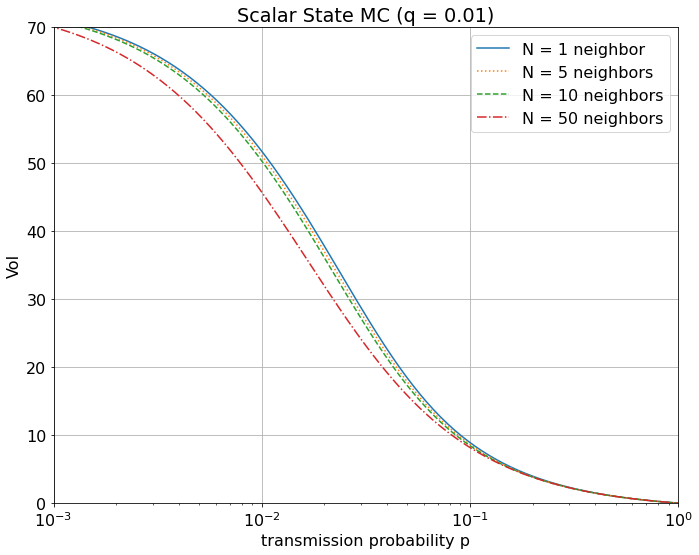

In [ ]:
p_start = 1e-5
p_end = 1
q = 0.01
max_aoi = 75

p_tx_vector = np.geomspace(p_start, p_end, 150)
N_vector = [1, 5, 10, 50]
average_aoi_matrix = np.zeros((len(N_vector), len(p_tx_vector)))

for i in range(len(N_vector)):
  N = N_vector[i]
  for j in range(len(p_tx_vector)):
    p_tx = p_tx_vector[j]

    p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)
    mat_transizione = create_transition_matrix(p, max_aoi)
    pi_vector_teorico = evaluate_stationary_prob_vector_1(mat_transizione)

    average_aoi = compute_average_AoI(pi_vector_teorico)

    average_aoi_matrix[i, j] = average_aoi

linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']
plt.figure(figsize = (10, 8))
for i in range(len(N_vector)):
  linestyle = linestyle_vector[i]
  plt.plot(p_tx_vector, average_aoi_matrix[i, :], linestyle = linestyle)

params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 16})
plt.xlabel("transmission probability p")
plt.ylabel("VoI")
plt.xlim([p_start * 100, p_end])
plt.ylim([0, 70])
plt.grid(True)
str_legend = ["N = {} neighbors".format(i) for i in N_vector]
str_legend[0] = str_legend[0][0:-1]
plt.legend(str_legend)
plt.title("Scalar State MC (q = " + str(q) +")")
plt.xscale('log')
plt.tight_layout()

file_type = 'png'
plt.savefig("SimpleMC_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_q" + str(int(q * 100)) + "." + file_type) 

file_type = 'eps'
plt.savefig("SimpleMC_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_q" + str(int(q * 100)) + "." + file_type) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

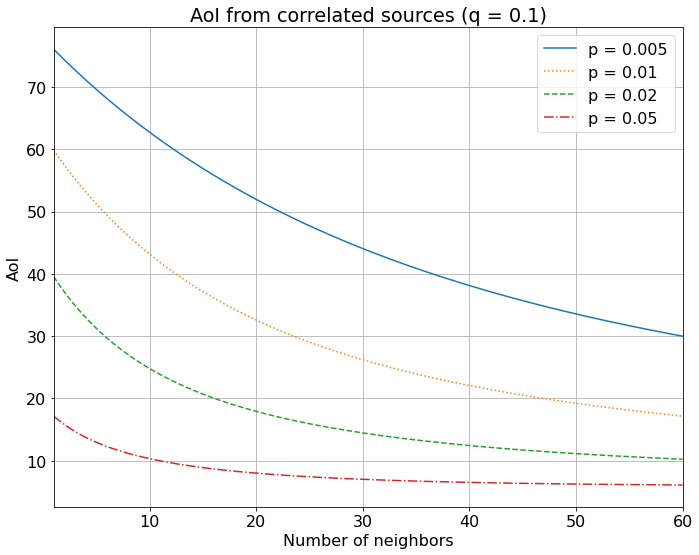

In [ ]:
p_start = 1e-5
p_end = 1
q = 0.1
max_aoi = 100

p_tx_vector = [5e-3, 1e-2, 2e-2, 5e-2]
N_vector = np.geomspace(1, 60, 350)
average_aoi_matrix = np.zeros((len(p_tx_vector), len(N_vector)))

for i in range(len(N_vector)):
  N = N_vector[i]
  for j in range(len(p_tx_vector)):
    p_tx = p_tx_vector[j]

    p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)
    mat_transizione = create_transition_matrix(p, max_aoi)
    pi_vector_teorico = evaluate_stationary_prob_vector_2(mat_transizione)

    average_aoi = compute_average_AoI(pi_vector_teorico)

    average_aoi_matrix[j, i] = average_aoi

linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']
plt.figure(figsize = (10, 8))
for i in range(len(p_tx_vector)):
  linestyle = linestyle_vector[i]
  plt.plot(N_vector, average_aoi_matrix[i, :], linestyle = linestyle)

params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 16})
plt.xlabel("Number of neighbors")
plt.ylabel("AoI")
plt.xlim([N_vector[0], N_vector[-1]])
plt.grid(True)
str_legend = ["p = {}".format(i) for i in p_tx_vector]
plt.legend(str_legend)
plt.title("AoI from correlated sources (q = " + str(q) +")")
# plt.xscale('log')
# plt.yscale('log')
plt.tight_layout()

file_type = 'png'
plt.savefig("SimpleMC_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_q" + str(int(q * 100)) + "." + file_type) 

file_type = 'eps'
plt.savefig("SimpleMC_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_q" + str(int(q * 100)) + "." + file_type) 

### Grafico con q interattivo

In [ ]:
def evaluate_p(q, max_aoi_visualized):
  # p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)

  p_tx_vector = np.linspace(0.01, 1, 50)
  N_vector = [5, 10, 15, 20, 25]

  average_aoi_matrix = np.zeros((len(N_vector), len(p_tx_vector)))

  for i in range(len(N_vector)):
    N = N_vector[i]
    for j in range(len(p_tx_vector)):
      p_tx = p_tx_vector[j]

      p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)
      mat_transizione = create_transition_matrix(p, max_aoi)
      pi_vector_teorico = evaluate_stationary_prob_vector_1(mat_transizione)

      average_aoi = compute_average_AoI(pi_vector_teorico)

      average_aoi_matrix[i, j] = average_aoi

  plt.figure(figsize = (10, 8))
  for i in range(len(N_vector)):
    plt.plot(p_tx_vector, average_aoi_matrix[i, :])

  params = {'mathtext.default': 'regular' }          
  plt.rcParams.update(params)
  plt.xlabel("$p_{tx}$")
  plt.ylabel("Average AoI")
  plt.xlim([0.01, 1])
  plt.ylim([0, max_aoi_visualized])
  plt.grid(True)
  plt.legend(N_vector)


interact(evaluate_p, q = (0.0, 0.5, 0.01), max_aoi_visualized = (0, 40, 1));

interactive(children=(FloatSlider(value=0.25, description='q', max=0.5, step=0.01), IntSlider(value=20, descri…

### Grafico con N e q interattivi

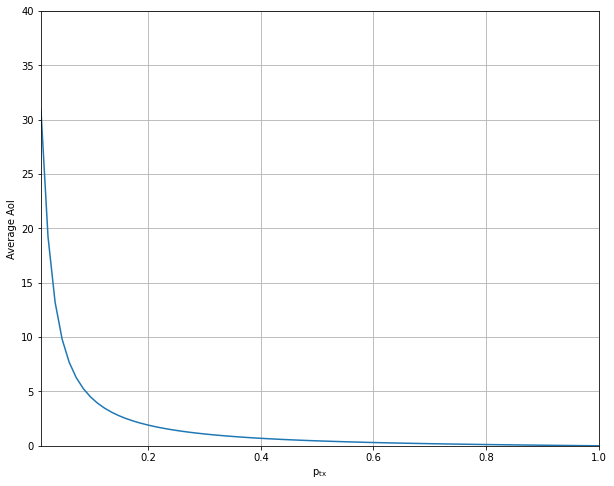

In [ ]:
def evaluate_p(q, N, max_aoi_visualized):
  # p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)

  p_tx_vector = np.linspace(0.01, 1, 80)

  average_aoi_vector = np.zeros((len(p_tx_vector)))


  for j in range(len(p_tx_vector)):
    p_tx = p_tx_vector[j]

    p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)
    mat_transizione = create_transition_matrix(p, max_aoi)
    pi_vector_teorico = evaluate_stationary_prob_vector_1(mat_transizione)

    average_aoi = compute_average_AoI(pi_vector_teorico)

    average_aoi_vector[j] = average_aoi

  plt.figure(figsize = (10, 8))
  plt.plot(p_tx_vector, average_aoi_vector)
  params = {'mathtext.default': 'regular' }          
  plt.rcParams.update(params)
  plt.xlabel("$p_{tx}$")
  plt.ylabel("Average AoI")
  plt.xlim([0.01, 1])
  plt.ylim([0, max_aoi_visualized])
  plt.grid(True)


interact(evaluate_p, q = (0.0, 1.0, 0.05), N = (0, 50, 2), max_aoi_visualized = (0, 40, 1));

## Confrontro modello teorico e MC

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

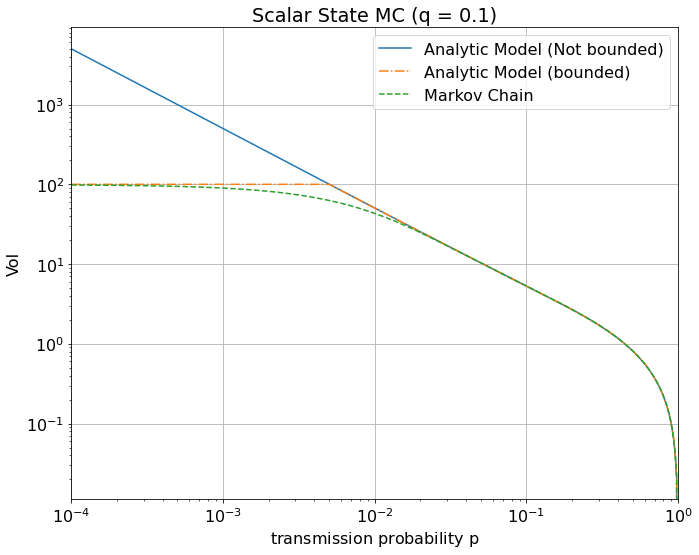

In [ ]:
def AoI(p, q, N, max_value = -1):
  x_1 = p
  x_2 = (1 - p) * (1 - (1 - p) ** N) * q

  AoI_value = 1 / (x_1 + x_2) - 1

  if(max_value > 0 and AoI_value > max_value): return max_value
  else: return AoI_value

p_start = 1e-4
p_end = 1
p_tx_vector = np.geomspace(p_start, p_end, 400)
q = 0.1
max_aoi = 100
N = 10

tmp_list = []
tmp_list_bounded = []

for p in p_tx_vector:
  tmp_list.append(AoI(p, q, N))
  tmp_list_bounded.append(AoI(p, q, N, max_aoi))


average_aoi_vector = np.zeros((len(p_tx_vector)))
for j in range(len(p_tx_vector)):
    p_tx = p_tx_vector[j]

    mat_transizione = create_transition_matrix(p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N), max_aoi)
    pi_vector_teorico = evaluate_stationary_prob_vector_1(mat_transizione)

    average_aoi = compute_average_AoI(pi_vector_teorico)
    average_aoi_vector[j] = average_aoi


plt.figure(figsize = (10, 8))
plt.plot(p_tx_vector, tmp_list, linestyle ='solid')
plt.plot(p_tx_vector, tmp_list_bounded, linestyle ='dashdot')
plt.plot(p_tx_vector, average_aoi_vector, linestyle ='dashed')
params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.xlabel("transmission probability $p$")
plt.ylabel("VoI")
plt.xlim([p_start, p_end])
# plt.ylim([0, 10**4])
plt.grid(True)
plt.title("Scalar State MC (q = " + str(q) + ")")
plt.legend(["Analytic Model (Not bounded)", "Analytic Model (bounded)", "Markov Chain"])
plt.xscale('log')
plt.yscale('log')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()


file_type = 'png'
plt.savefig("SimpleMC_comparison_maths_model_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_comparison_maths_model_q" + str(int(q * 100)) + "." + file_type) 

file_type = 'eps'
plt.savefig("SimpleMC_comparison_maths_model_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_comparison_maths_model_q" + str(int(q * 100)) + "." + file_type) 

## Variando c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

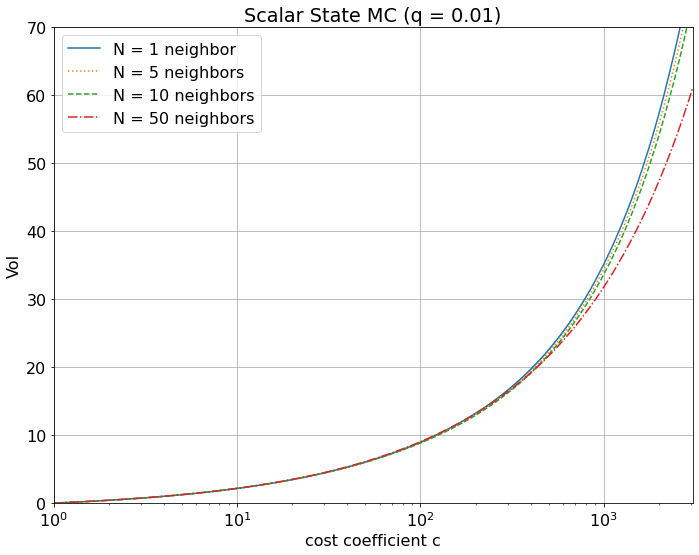

In [ ]:
p_start = 1e-4
p_end = 1
p_tx_vector = np.geomspace(p_start, p_end, 3000)
N_vector = [1, 5, 10, 50]
q = 0.01
max_aoi = 75
add_c = False
linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']

average_aoi_matrix = np.zeros((len(N_vector), len(p_tx_vector)))

for i in range(len(N_vector)):
  N = N_vector[i]
  for j in range(len(p_tx_vector)):
    p_tx = p_tx_vector[j]

    p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)
    mat_transizione = create_transition_matrix(p, max_aoi)
    pi_vector_teorico = evaluate_stationary_prob_vector_1(mat_transizione)

    average_aoi = compute_average_AoI(pi_vector_teorico)

    average_aoi_matrix[i, j] = average_aoi

def find_idx_p_given_c(c, aoi_vector, p_tx_vector):
  aoi_derivative = np.gradient(aoi_vector, p_tx_vector)

  idx_list = (np.abs(aoi_derivative + c)).argsort()[:2]

  # idx = (np.abs(aoi_derivative + c)).argmin()
  idx = max(idx_list)

  return idx


c_vector = np.geomspace(1, 10000, len(p_tx_vector))

fig, ax = plt.subplots(1, 1, figsize = (10, 8))

for i in range(len(N_vector)):
  p_given_c = []
  aoi_given_c = []
  voi_given_c = []
  for c in c_vector:
    average_aoi_vector_2 = average_aoi_matrix[i]
    idx = find_idx_p_given_c(c, average_aoi_vector_2, p_tx_vector)
    # print(idx)

    p_given_c.append(p_tx_vector[idx])
    if(add_c):
      voi_given_c.append(-(average_aoi_vector_2[idx] + c * p_tx_vector[idx]))
    else:
      voi_given_c.append(average_aoi_vector_2[idx])
    

  ax.plot(c_vector, voi_given_c, linestyle = linestyle_vector[i])

average_aoi_matrix_simple = average_aoi_matrix

if(add_c):
  ax.set_title("Value of Information (q = {})".format(q))
else:
  ax.set_title("Scalar State MC (q = {})".format(q))
ax.set_ylabel("VoI")
ax.set_xscale('log')
# ax.set_yscale('symlog')
ax.set_xlabel("cost coefficient c")

str_legend = ["N = {} neighbors".format(i) for i in N_vector]
str_legend[0] = str_legend[0][0:-1]
ax.legend(str_legend)
ax.set_xlim([1, 1e3 * 3.05])
ax.set_ylim([0, 70])
ax.grid(True)

params = {'mathtext.default': 'regular', 'font.size': 16}       
plt.rcParams.update(params)
plt.tight_layout()

file_type = 'png'
plt.savefig("SimpleMC_c_plot_model_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_c_plot_model_q" + str(int(q * 100)) + "." + file_type) 

file_type = 'eps'
plt.savefig("SimpleMC_c_plot_model_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_c_plot_model_q" + str(int(q * 100)) + "." + file_type) 

## Variando q

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

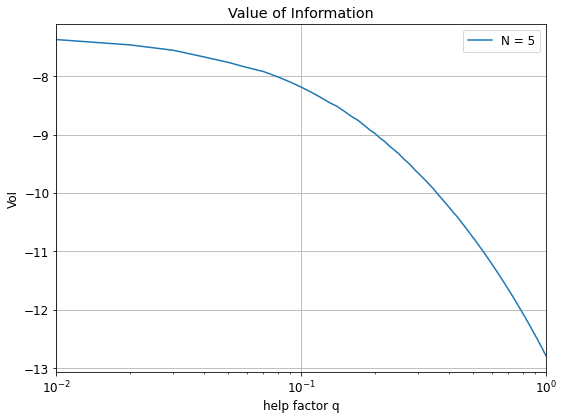

In [ ]:
# p_start = 1e-4
# p_end = 1
# p_tx_vector = np.geomspace(p_start, p_end, 1000)
# q_vector = np.linspace(0.01, 1, 100)
# N = 5
# max_aoi = 200
c = 10

# average_aoi_matrix = np.zeros((len(q_vector), len(p_tx_vector)))

# for i in range(len(q_vector)):
#   q = q_vector[i]
#   for j in range(len(p_tx_vector)):
#     p_tx = p_tx_vector[j]

#     p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)
#     mat_transizione = create_transition_matrix(p, max_aoi)
#     pi_vector_teorico = evaluate_stationary_prob_vector_1(mat_transizione)

#     average_aoi = compute_average_AoI(pi_vector_teorico)

#     average_aoi_matrix[i, j] = average_aoi

def find_idx_p_given_c(c, aoi_vector, p_tx_vector):
  aoi_derivative = np.gradient(aoi_vector, p_tx_vector)

  idx_list = (np.abs(aoi_derivative + c)).argsort()[:2]

  # idx = (np.abs(aoi_derivative + c)).argmin()
  idx = max(idx_list)

  return idx


c_vector = np.linspace(1, 1000, len(q_vector))

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
aoi_given_q = []
for i in range(len(q_vector)):

  average_aoi_vector_2 = average_aoi_matrix[i]
  idx = find_idx_p_given_c(c, average_aoi_vector_2, p_tx_vector)


  p_tmp = p_tx_vector[idx]
  p = (1 - p_tmp) + (1 - p_tmp) * (1 - (1 - p_tmp) ** N) * q_vector[i]

  aoi_given_q.append(-(1/p - 1 + c * p))

# print(aoi_given_q)
ax.plot(q_vector, aoi_given_q)
  # ax[1].plot(c_vector, aoi_given_q)

ax.set_title("Value of Information".format(q))
ax.set_xscale('log')
ax.set_xlabel("help factor q")
ax.set_ylabel("VoI")
ax.legend(["N = {}".format(N)])
ax.set_xlim([q_vector[0], q_vector[-1]])
ax.grid(True)

params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 12})
plt.tight_layout()

file_type = 'png'
plt.savefig("SimpleMC_c_plot_model_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_c_plot_model_q" + str(int(q * 100)) + "." + file_type) 

file_type = 'eps'
plt.savefig("SimpleMC_c_plot_model_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("SimpleMC_c_plot_model_q" + str(int(q * 100)) + "." + file_type) 

# Markov chain Complicata

Catena bidimensionale. Con probabilità $p_{tx}$ trasmetto io e con probabilità $\beta$ trasmette almeno un vicino.

## Dichiarazione funzioni 

In [ ]:
from termcolor import colored

def create_transition_matrix_V2(p, beta, max_aoi):
  mat_1 = create_transition_matrix(p, max_aoi)
  mat_1[mat_1 == (1-p)] = (1-p) * (1 - beta)

  # Create the first "column"
  first_column_list = [mat_1]
  for i in range(1, max_aoi):
    current_size = max_aoi - i
    tmp_mat = np.zeros((current_size, max_aoi))
    tmp_mat[:,0] = p
    first_column_list.append(tmp_mat)

  first_column = np.concatenate(first_column_list, axis = 0)
  # print(first_column)

  # Create the second "column"
  second_column_list = []
  for i in range(max_aoi):
    current_size = max_aoi - i
    tmp_mat = np.ones((current_size, max_aoi - 1)) * (1 - p) * beta

    tmp_mat = np.triu(tmp_mat, i)
    tmp_mat = np.tril(tmp_mat, i)
    tmp_mat[-1, -1] = (1 - p) * beta
    second_column_list.append(tmp_mat)

  second_column = np.concatenate(second_column_list, axis = 0)
  # print(second_column)

  # Create all other columns
  column_list = [first_column, second_column]
  for i in range(max_aoi - 2):
    tmp_column_list = []
    for j in range(max_aoi):
      if(j == (i + 1)):
        tmp_mat = np.ones((max_aoi - j, max_aoi - (i + 2))) *  (1 - p) * (1 - beta)
        tmp_mat = np.triu(tmp_mat, j - (i + 1))
        tmp_mat = np.tril(tmp_mat, j - (i + 1))
        tmp_mat[-1, -1] = (1 - p) * (1 - beta)
      else:
        tmp_mat = np.zeros((max_aoi - j, max_aoi - (i + 2)))
      tmp_column_list.append(tmp_mat)

    tmp_column = np.concatenate(tmp_column_list, axis = 0)
    column_list.append(tmp_column)
    tmp_column_list = []

  mat_transizione = np.hstack(column_list)
  mat_transizione[-1, -1] = (1 - p) * (1 - beta)
  # print(mat_transizione.shape)

  return mat_transizione


def compute_average_AoI_2(stationary_prob_vector, max_aoi, alpha = 0.1, print_var = False):
  # Max number of state if my neighbor is in more update state that mine (Guarda disegno su iPad)
  max_states_per_neighbor_state = max_aoi  - 1 
  count_states = 0
  neighbor_age = 0
  my_age = 0
  average_aoi = 0



  for k in range(len(stationary_prob_vector)):
    average_aoi += my_age * stationary_prob_vector[k]

    if(k > max_aoi):
      average_aoi -= alpha * (my_age - neighbor_age) * stationary_prob_vector[k]
      count_states += 1
      # print(k, "\t", my_age,  "\t", sum_1, "\t", neighbor_age, count_states, max_states_per_neighbor_state)
      my_age += 1

      if(count_states >= max_states_per_neighbor_state):
        count_states = 0
        max_states_per_neighbor_state -= 1
        neighbor_age += 1
        my_age = neighbor_age + 1

    elif(k == (max_aoi - 1)):
      # print(k, "\t", my_age,  "\t", sum_1, "aaaaa")
      my_age = 1
      count_states += 1
    else:
      # print(k, "\t", my_age,  "\t", sum_1)
      my_age += 1
     

  # if(print_var):
  #   print(round(sum_1, 3), "\t\t", round(sum_2, 3), "\t\t", round(sum_1/sum_2, 3))
  #   # print(sum_1 - sum_2, average_aoi)

  return average_aoi

## Test singolo

In [ ]:
p = 0.2072921779595372
p = 0.2
N = 5

beta = 1 - (1 - p) ** N
max_aoi = 7
print("q * alpha = ", (1 - p) * (1 - beta))
print("q * alpha = ", (1 - p) * (beta))

mat_transizione = create_transition_matrix_V2(p, beta, max_aoi)
print("Shape transition matrix:", mat_transizione.shape)
# print(mat_transizione)
# print("\nk\tmy_age\tsum_1")

# pi_vector_teorico = evaluate_stationary_prob_vector_1(mat_transizione)
# pi_vector_pratico = evaluate_stationary_prob_vector_2(mat_transizione, n_iterations = 4)
pi_vector_pratico = evaluate_stationary_prob_vector_3(mat_transizione, n_iterations = 20)

# average_aoi_teorico = compute_average_AoI_2(pi_vector_teorico, max_aoi, alpha = 0.1)
# average_aoi_pratico = compute_average_AoI_2(pi_vector_pratico, max_aoi, alpha = 0.1)
average_aoi_pratico = compute_average_AoI_2(pi_vector_pratico, max_aoi, alpha = 0.1, print_var = True)

# print("Average AoI (teo): ", average_aoi_teorico)
print("Average AoI (pra): ", average_aoi_pratico)

tmp_string = ""
for i in range(mat_transizione.shape[0]):
  for j in range(mat_transizione.shape[1]):
    if(mat_transizione[i, j] == 0.2): tmp_char = '$p$'
    elif(mat_transizione[i, j] == 0.262144): tmp_char = '$(1 - p)(1 - beta)$'
    elif(mat_transizione[i, j] == 0.537856): tmp_char = '$(1 - p)beta$'
    else: tmp_char = str(0)
    tmp_string += tmp_char + "&"
  tmp_string += "\n"

# print(tmp_string)

q * alpha =  0.2621440000000001
q * alpha =  0.537856
Shape transition matrix: (28, 28)
Average AoI (pra):  2.7025313344339637


In [ ]:
p_start = 1e-4
p_end = 1
p_tx_vector = np.geomspace(p_start, p_end, 450)
N_vector = [1, 5, 10, 50]
max_aoi = 75
alpha = 0.1
print_var = True

average_aoi_matrix = np.zeros((len(N_vector), len(p_tx_vector)))

for i in range(len(N_vector)):
  N = N_vector[i]
  print(i)
  for j in range(len(p_tx_vector)):
    # print("\t", j)
    p = p_tx_vector[j]
    beta = 1 - (1 - p) ** N

    mat_transizione = create_transition_matrix_V2(p, beta, max_aoi)
    # pi_vector = evaluate_stationary_prob_vector_1(mat_transizione)
    # pi_vector = evaluate_stationary_prob_vector_2(mat_transizione, 4)
    pi_vector = evaluate_stationary_prob_vector_3(mat_transizione, 10)

    # if(j > 425): print_var = True

    average_aoi = compute_average_AoI_2(pi_vector, max_aoi, alpha, print_var = print_var)

    average_aoi_matrix[i, j] = average_aoi

0
1
2
3


### Test Plot AoI

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

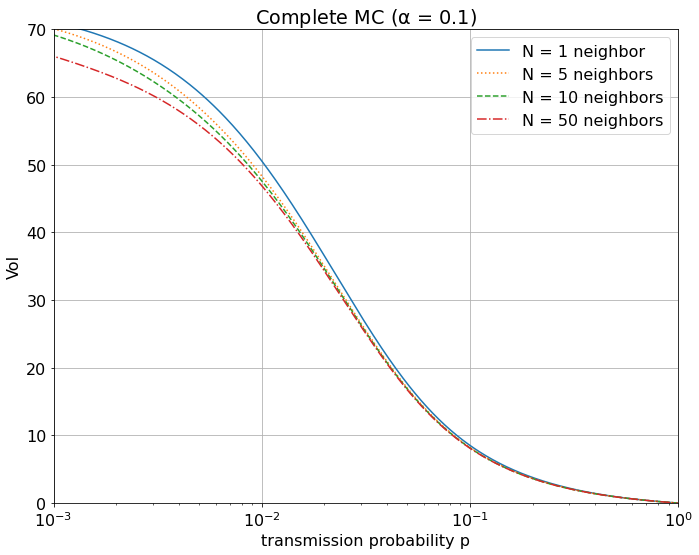

In [ ]:
average_aoi_matrix = average_aoi_matrix_2

linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
for i in range(len(N_vector)):
  linestyle = linestyle_vector[i]
  ax.plot(p_tx_vector, average_aoi_matrix[i, :], linestyle = linestyle)

params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)
plt.xlabel("transmission probability p")
ax.set_ylabel("VoI")
ax.set_xscale('log')
ax.set_xlim([p_start * 10, p_end])
ax.set_ylim([0, 70])
ax.grid(True)
str_legend = ["N = {} neighbors".format(i) for i in N_vector]
str_legend[0] = str_legend[0][0:-1]
ax.legend(str_legend)
ax.set_title(r'Complete MC ($\alpha$ = {})'.format(alpha))

plt.rcParams.update({'font.size': 16})
plt.tight_layout()

file_type = 'png'
plt.savefig("ComplexMC_alpha_{}.".format(int(alpha * 100)) + file_type, format=file_type)
files.download("ComplexMC_alpha_{}.".format(int(alpha * 100)) + file_type) 

file_type = 'eps'
plt.savefig("ComplexMC_alpha_{}.".format(int(alpha * 100)) + file_type, format=file_type)
files.download("ComplexMC_alpha_{}.".format(int(alpha * 100)) + file_type) 

### Test Plot C

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

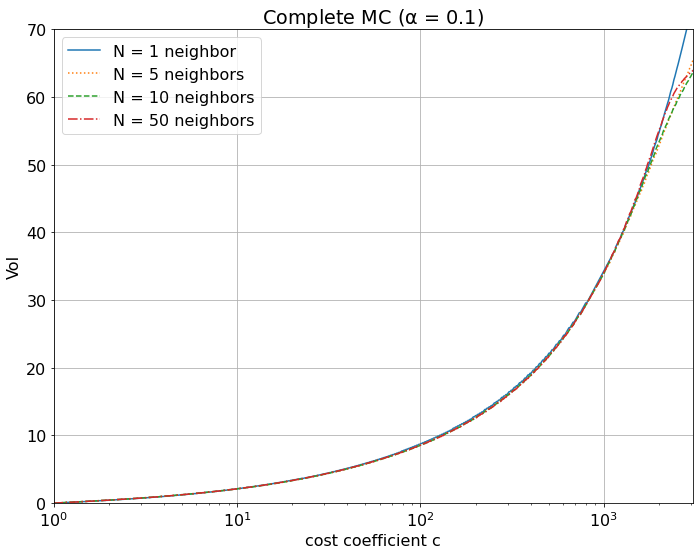

In [ ]:
c_vector = np.geomspace(1, 10000, len(p_tx_vector))
add_cost = False

fig, ax = plt.subplots(1, 1, figsize = (10, 8))

linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']

for i in range(len(N_vector)):
  p_given_c = []
  aoi_given_c = []
  voi_given_c = []
  for c in c_vector:
    average_aoi_vector_2 = average_aoi_matrix[i]
    idx = find_idx_p_given_c(c, average_aoi_vector_2, p_tx_vector)
    # print(idx)

    p_given_c.append(p_tx_vector[idx])
    if(add_cost):
      voi_given_c.append(-(average_aoi_vector_2[idx] + c * p_tx_vector[idx]))
    else:
      voi_given_c.append(average_aoi_vector_2[idx])
  
  linestyle = linestyle_vector[i]
  ax.plot(c_vector, voi_given_c, linestyle = linestyle)


if(add_cost):
  ax.set_title(r'VoI  + cost($\alpha$ = {})'.format(alpha))
else:
  ax.set_title(r'Complete MC ($\alpha$ = {})'.format(alpha))

ax.set_ylabel("VoI")
ax.set_xscale('log')
# ax.set_yscale('symlog')
# ax.set_ylim([-40, -1])
ax.set_xlabel("cost coefficient c")

str_legend = ["N = {} neighbors".format(i) for i in N_vector]
str_legend[0] = str_legend[0][0:-1]
ax.legend(str_legend)
ax.set_xlim([1, 1e3 * 3.05])
ax.set_ylim([0, 70])
ax.grid(True)


params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

file_type = 'png'
plt.savefig("ComplexMC_c_plot_alpha_{}.".format(int(alpha * 100)) + file_type, format=file_type)
files.download("ComplexMC_c_plot_alpha_{}.".format(int(alpha * 100)) + file_type) 

file_type = 'eps'
plt.savefig("ComplexMC_c_plot_alpha_{}.".format(int(alpha * 100)) + file_type, format=file_type)
files.download("ComplexMC_c_plot_alpha_{}.".format(int(alpha * 100)) + file_type) 

### Test plot C (con p catena semplice)

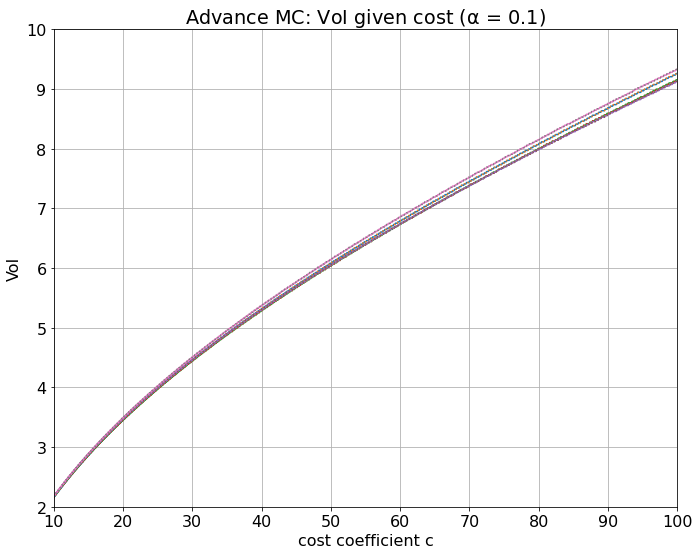

In [ ]:
c_vector = np.geomspace(5, 400, len(p_tx_vector))
add_cost = False
N_vector = [1, 5, 10, 50]
# N_vector = [1, 5]

fig, ax = plt.subplots(1, 1, figsize = (10, 8))

linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']

for i in range(len(N_vector)):
  p_given_c = []
  voi_given_c = []
  voi_given_c_2 = []
  for c in c_vector:
    average_aoi_vector_2 = average_aoi_matrix[i]
    idx = find_idx_p_given_c(c, average_aoi_vector_2, p_tx_vector)
    # print(idx)

    p_given_c.append(p_tx_vector[idx])
    if(add_cost):
      voi_given_c.append(-(average_aoi_vector_2[idx] + c * p_tx_vector[idx]))
    else:
      voi_given_c.append(average_aoi_vector_2[idx])

     
    average_aoi_vector_2_simple = average_aoi_matrix_simple[i]
    idx = find_idx_p_given_c(c, average_aoi_vector_2_simple, p_tx_vector)

    if(add_cost):
      voi_given_c_2.append(-(average_aoi_vector_2[idx] + c * p_tx_vector[idx]))
    else:
      voi_given_c_2.append(average_aoi_vector_2[idx])
  
  linestyle = linestyle_vector[i]
  ax.plot(c_vector, voi_given_c, linestyle = 'solid')
  ax.plot(c_vector, voi_given_c_2, linestyle = 'dotted')


if(add_cost):
  ax.set_title(r'VoI  + cost($\alpha$ = {})'.format(alpha))
else:
  ax.set_title(r'Advance MC: VoI given cost ($\alpha$ = {})'.format(alpha))

ax.set_ylabel("VoI")
# ax.set_xscale('log')
# ax.set_yscale('symlog')
ax.set_xlabel("cost coefficient c")

# ax.legend(["N of neighbor = " + str(i) for i in N_vector])
# ax.legend(["1", "2"])
ax.set_xlim([10, 100])
ax.set_ylim([2, 10])
ax.grid(True)


params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

# print(np.asarray(voi_given_c_2) - np.asarray(voi_given_c))
# print(average_aoi_vector_2_simple - average_aoi_vector_2)

# file_type = 'png'
# plt.savefig("ComplexMC_c_plot_alpha_{}.".format(int(alpha * 100)) + file_type, format=file_type)
# files.download("ComplexMC_c_plot_alpha_{}.".format(int(alpha * 100)) + file_type) 

# file_type = 'eps'
# plt.savefig("ComplexMC_c_plot_alpha_{}.".format(int(alpha * 100)) + file_type, format=file_type)
# files.download("ComplexMC_c_plot_alpha_{}.".format(int(alpha * 100)) + file_type) 

## Confronto modello teorico e MC complessa

In [ ]:
def AoI(p, N, alpha = 0.1, max_value = -1):
  x_1 = 1/p
  x_2 = (N/(N + 1)) * (1/p - 1 / ((1 - (1 - p) ** N)))

  AoI_value = x_1 - 1 - alpha * (x_1 - x_2)

  if(max_value > 0 and AoI_value > max_value): return max_value
  else: return AoI_value

p_start = 1e-4
p_end = 1
p_tx_vector = np.geomspace(p_start, p_end, 200)
max_aoi = 100
N = 10

tmp_list = []
tmp_list_bounded = []
prev_sum_1 = prev_sum_2 = 0

average_aoi_vector = np.zeros((len(p_tx_vector)))
for j in range(len(p_tx_vector)):
    p = p_tx_vector[j]
    beta = 1 - ((1 - p) ** N)
    

    mat_transizione = create_transition_matrix_V2(p, beta, max_aoi)
    pi_vector = evaluate_stationary_prob_vector_3(mat_transizione)

    average_aoi = compute_average_AoI_2(pi_vector, max_aoi)
    average_aoi_vector[j] = average_aoi

    tmp_list.append(AoI(p, N, max_value = -1))
    tmp_list_bounded.append(AoI(p, N, max_value = max_aoi))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

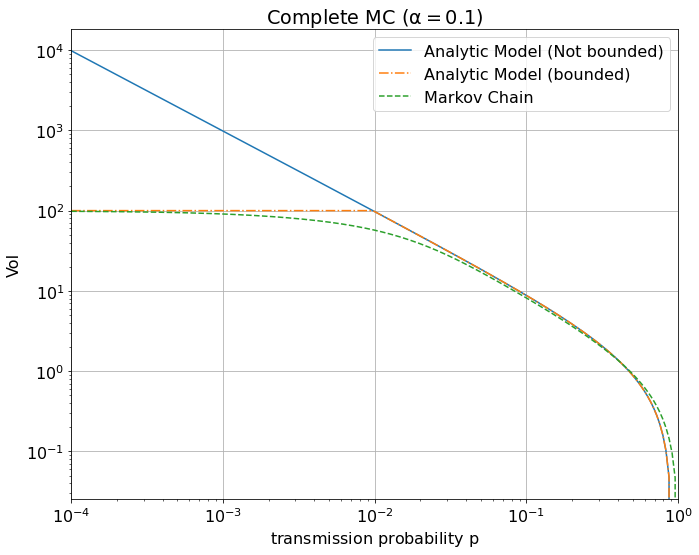

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(p_tx_vector, tmp_list, linestyle ='solid')
plt.plot(p_tx_vector, tmp_list_bounded, linestyle ='dashdot')
plt.plot(p_tx_vector, average_aoi_vector, linestyle ='dashed')
params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.xlabel("transmission probability $p$")
plt.ylabel("VoI")
plt.xlim([p_start, p_end])
plt.grid(True)
plt.title(r'Complete MC ($\alpha = {}$)'.format(alpha))
plt.legend(["Analytic Model (Not bounded)", "Analytic Model (bounded)", "Markov Chain"])
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.rcParams.update({'font.size': 16})

file_type = 'png'
plt.savefig("complexMC_comparison_maths_model_alpha" + str(int(alpha * 100)) + "." + file_type, format=file_type)
files.download("complexMC_comparison_maths_model_alpha" + str(int(alpha * 100)) + "." + file_type) 

file_type = 'eps'
plt.savefig("complexMC_comparison_maths_model_alpha" + str(int(alpha * 100)) + "." + file_type, format=file_type)
files.download("complexMC_comparison_maths_model_alpha" + str(int(alpha * 100)) + "." + file_type) 

# plt.figure()
# plt.plot(p_tx_vector[1:], np.diff(tmp_list))
# plt.plot(p_tx_vector[1:], np.diff(average_aoi_vector))
# plt.xscale('log')

# Confronti vari

## Confronto MC semplice e complicata

In [ ]:
p_start = 1e-4
p_end = 1
p_tx_vector = np.geomspace(p_start, p_end, 700)
N_vector = [1, 5, 10, 50]
q = 0.01
max_aoi = 75
alpha = 0.1


average_aoi_matrix_1 = np.zeros((len(N_vector), len(p_tx_vector)))
average_aoi_matrix_2 = np.zeros((len(N_vector), len(p_tx_vector)))
simple_MC_vector_list = []
complex_MC_vector_list = []

for i in range(len(N_vector)):
  print(i)
  N = N_vector[i]
  tmp_vector_list_1 = []
  tmp_vector_list_2 = []
  for j in range(len(p_tx_vector)):

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Simple MC
    p_tx = p_tx_vector[j]
    p = p_tx + q * (1 - p_tx) * (1 - (1 - p_tx)** N)
    mat_transizione_1 = create_transition_matrix(p, max_aoi)
    
    pi_vector_teorico = evaluate_stationary_prob_vector_3(mat_transizione_1)
    tmp_vector_list_1.append(pi_vector_teorico)

    average_aoi_1 = compute_average_AoI(pi_vector_teorico)
    average_aoi_matrix_1[i, j] = average_aoi_1
    

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Complex MC

    p = p_tx_vector[j]
    beta = 1 - (1 - p) ** N
    mat_transizione_2 = create_transition_matrix_V2(p, beta, max_aoi)

    pi_vector_teorico = evaluate_stationary_prob_vector_3(mat_transizione_2, n_iterations = 10)
    tmp_vector_list_2.append(pi_vector_teorico)

    average_aoi_2 = compute_average_AoI_2(pi_vector_teorico, max_aoi, alpha)
    average_aoi_matrix_2[i, j] = average_aoi_2


  simple_MC_vector_list.append(tmp_vector_list_1)
  complex_MC_vector_list.append(tmp_vector_list_2)

# print(j)
# print(len(tmp_vector_list_1))
# print(len(tmp_vector_list_2))

0
1
2
3


### Plot Aoi/Derivate

In [ ]:
def compute_average_AoI_vector(p_vector, steady_state_prob_vector_list, mc_type, max_aoi = -1, w1 = 0.5, w_2 = 0-5):
  aoi_vector = np.zeros(len(p_vector))

  for i in range(len(p_vector)):
    steady_state_prob_vector = steady_state_prob_vector_list[i]
    # print(steady_state_prob_vector.shape)

    if(mc_type == 'simple'):  aoi_vector[i] = compute_average_AoI(steady_state_prob_vector)
    elif(mc_type == 'complex' and max_aoi != -1):  aoi_vector[i] = compute_average_AoI_2(steady_state_prob_vector, max_aoi, w_1, w_2)
    else: print("ERROR")

  return aoi_vector

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

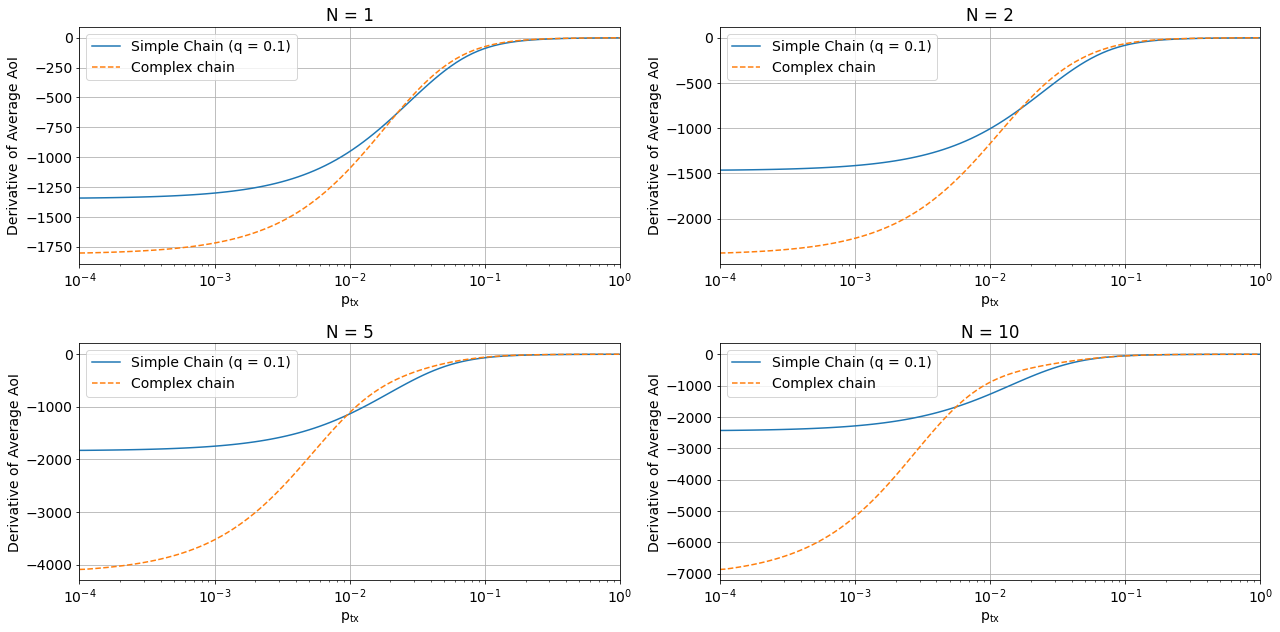

In [ ]:
# p_start = 1e-4
# p_end = 1
# p_tx_vector = np.geomspace(p_start, p_end, 150)
use_derivative = True

# simple_MC_pi_vectors = np.load("/content/drive/MyDrive/Colab Notebooks/Saved Variables/simple_MC_q10.npy")
# complex_MC_pi_vectors = np.load("/content/drive/MyDrive/Colab Notebooks/Saved Variables/complex_MC.npy")
simple_MC_pi_vectors = np.asarray(simple_MC_vector_list)
complex_MC_pi_vectors = np.asarray(complex_MC_vector_list)

fig, ax = plt.subplots(2, 2, figsize = (18, 9))
idx = 0
for i in range(2):
  for j in range(2):
    average_aoi_vector_1 = compute_average_AoI_vector(p_tx_vector, simple_MC_pi_vectors[idx], 'simple')
    average_aoi_vector_2 = compute_average_AoI_vector(p_tx_vector, complex_MC_pi_vectors[idx], 'complex', max_aoi)

    if(use_derivative):
      ax[i, j].plot(p_tx_vector, np.gradient(average_aoi_vector_1, p_tx_vector), linestyle = 'solid')
      ax[i, j].plot(p_tx_vector, np.gradient(average_aoi_vector_2, p_tx_vector), linestyle = 'dashed')
      ax[i, j].set_ylabel("Derivative of Average AoI")
    else:
      ax[i, j].plot(p_tx_vector, average_aoi_vector_1, linestyle = 'solid')
      ax[i, j].plot(p_tx_vector, average_aoi_vector_2, linestyle = 'dashed')
      ax[i, j].set_ylabel("Average AoI")

    ax[i, j].set_title("N = " + str(N_vector[idx]))
    ax[i, j].grid(True)
    ax[i, j].set_xlim([p_start, p_end])
    ax[i, j].legend(["Simple Chain (q = {})".format(q), "Complex chain"])
    ax[i, j].set_xscale('log')
    ax[i, j].set_xlabel("$p_{tx}$")
    idx += 1

params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

file_type = 'png'
plt.savefig("MC_Comparison_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("MC_Comparison_q" + str(int(q * 100)) + "." + file_type) 

file_type = 'eps'
plt.savefig("MC_Comparison_q" + str(int(q * 100)) + "." + file_type, format=file_type)
files.download("MC_Comparison_q" + str(int(q * 100)) + "." + file_type) 

In [ ]:
# file_name = "simple_MC_q{}".format(int(q * 100))
# np.save("/content/drive/MyDrive/Colab Notebooks/Saved Variables/{}.npy".format(file_name), np.asarray(simple_MC_vector_list))

# file_name = "complex_MC"
# np.save("/content/drive/MyDrive/Colab Notebooks/Saved Variables/{}.npy".format(file_name), np.asarray(simple_MC_vector_list))

# print(np.load("/content/drive/MyDrive/Colab Notebooks/Saved Variables/simple_MC_q10.npy"))

[]


## Confronto w per N fissati

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

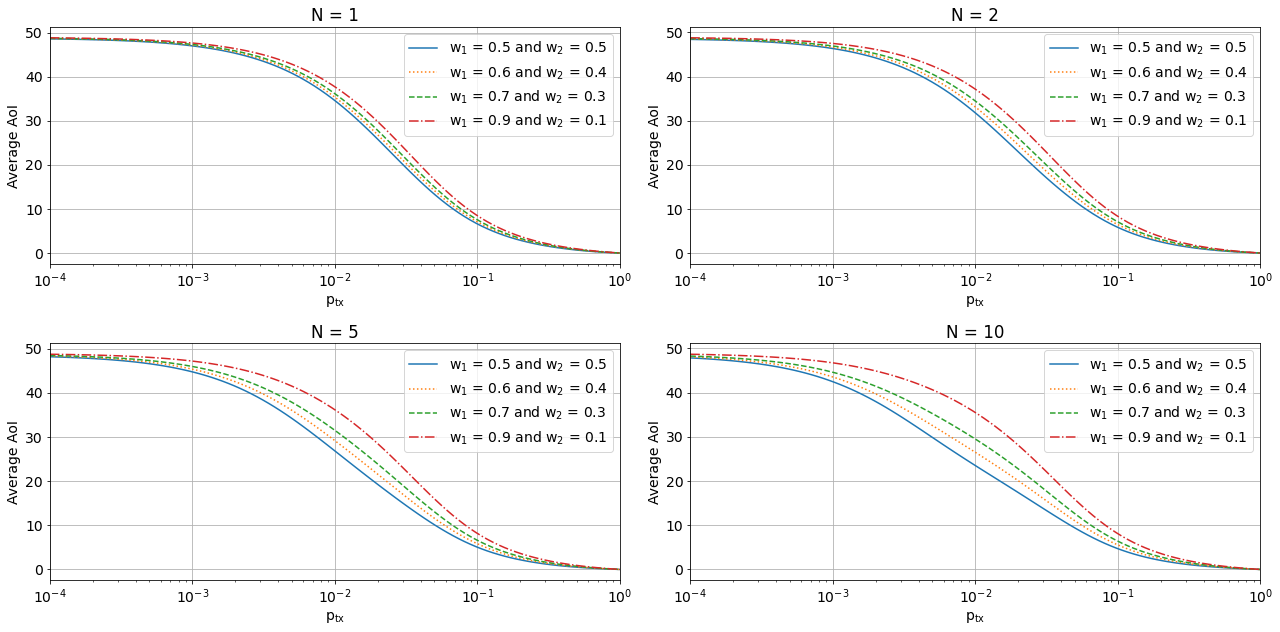

In [ ]:
use_derivative = False
linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']

complex_MC_pi_vectors = np.asarray(complex_MC_vector_list)
# print(complex_MC_pi_vectors.shape)

fig, ax = plt.subplots(2, 2, figsize = (18, 9))
idx = 0

w_couple_list = [(0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.9, 0.1)]
for i in range(2):
  for j in range(2):
    for k in range(len(w_couple_list)):
      w_couple = w_couple_list[k]
      w_1 = w_couple[0]
      w_2 = w_couple[1]

      average_aoi_vector_2 = compute_average_AoI_vector(p_tx_vector, complex_MC_pi_vectors[idx], 'complex', max_aoi, w_1, w_2)

      if(use_derivative):
        ax[i, j].plot(p_tx_vector, np.gradient(average_aoi_vector_2, p_tx_vector), linestyle = linestyle_vector[k])
        ax[i, j].set_ylabel("Derivative of Average AoI")
      else:
        ax[i, j].plot(p_tx_vector, average_aoi_vector_2, linestyle = linestyle_vector[k])
        ax[i, j].set_ylabel("Average AoI")

    ax[i, j].set_title("N = " + str(N_vector[idx]))
    ax[i, j].grid(True)
    ax[i, j].set_xlim([p_start, p_end])
    ax[i, j].legend(["$w_1$ = {} and $w_2$ = {}".format(w_couple[0], w_couple[1]) for w_couple in w_couple_list])
    ax[i, j].set_xscale('log')
    ax[i, j].set_xlabel("$p_{tx}$")
    idx += 1


params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 14})
plt.tight_layout()


file_type = 'png'
plt.savefig("ComplexMC_w_comparison." + file_type, format=file_type)
files.download("ComplexMC_w_comparison." + file_type) 

file_type = 'eps'
plt.savefig("ComplexMC_w_comparison." + file_type, format=file_type)
files.download("ComplexMC_w_comparison." + file_type) 

## Confronto MC - p dato c

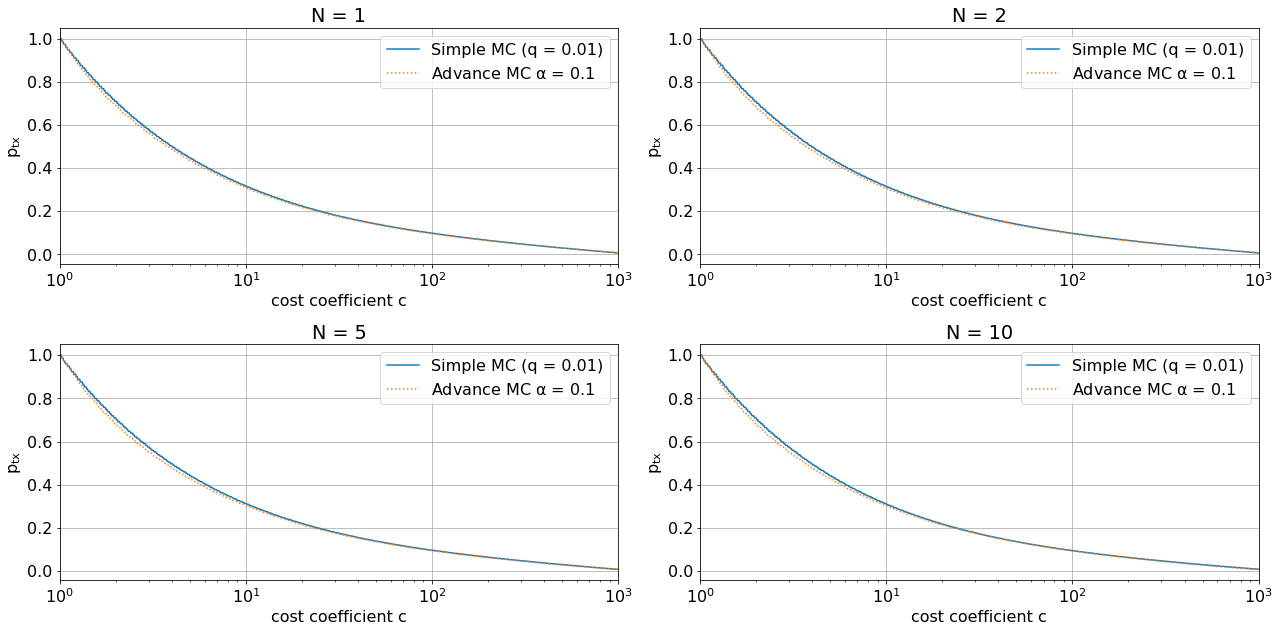

In [ ]:
# p_start = 1e-4
# p_end = 1
# p_tx_vector = np.geomspace(p_start, p_end, 150)
c_vector = np.geomspace(1, 1000, len(p_tx_vector))
use_voi = False
linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']

# simple_MC_pi_vectors = np.load("/content/drive/MyDrive/Colab Notebooks/Saved Variables/simple_MC_q10.npy")
# complex_MC_pi_vectors = np.load("/content/drive/MyDrive/Colab Notebooks/Saved Variables/complex_MC.npy")
simple_MC_pi_vectors = np.asarray(simple_MC_vector_list)
complex_MC_pi_vectors = np.asarray(complex_MC_vector_list)

fig, ax = plt.subplots(2, 2, figsize = (18, 9))
idx = 0
for i in range(2):
  for j in range(2):
    # average_aoi_vector_1 = compute_average_AoI_vector(p_tx_vector, simple_MC_pi_vectors[idx], 'simple')
    # average_aoi_vector_2 = compute_average_AoI_vector(p_tx_vector, complex_MC_pi_vectors[idx], 'complex', max_aoi)
    average_aoi_vector_1 = average_aoi_matrix_1[idx]
    average_aoi_vector_2 = average_aoi_matrix_2[idx]

    p_given_c_1 = []
    aoi_given_c_1 = []
    voi_given_c_1 = []

    p_given_c_2 = []
    aoi_given_c_2 = []
    voi_given_c_2 = []

    for c in c_vector:
      idx_1 = find_idx_p_given_c(c, average_aoi_vector_1, p_tx_vector)
      idx_2 = find_idx_p_given_c(c, average_aoi_vector_2, p_tx_vector)

      p_given_c_1.append(p_tx_vector[idx_1])
      aoi_given_c_1.append(average_aoi_vector_2[idx_1])
      voi_given_c_1.append(-(average_aoi_vector_2[idx_1] + c * p_tx_vector[idx_1]))

      p_given_c_2.append(p_tx_vector[idx_2])
      aoi_given_c_2.append(average_aoi_vector_2[idx_2])
      voi_given_c_2.append(-(average_aoi_vector_2[idx_2] + c * p_tx_vector[idx_2]))
    
    if(use_voi):
      ax[i, j].plot(c_vector, voi_given_c_1, linestyle = linestyle_vector[0])
      ax[i, j].plot(c_vector, voi_given_c_2, linestyle = linestyle_vector[1])
      ax[i, j].set_ylabel("VoI")
    else:
      ax[i, j].plot(c_vector, p_given_c_1, linestyle = linestyle_vector[0])
      ax[i, j].plot(c_vector, p_given_c_2, linestyle = linestyle_vector[1])
      ax[i, j].set_ylabel("$p_{tx}$")

      # ax[i, j].plot(c_vector, aoi_given_c_1, linestyle = linestyle_vector[0])
      # ax[i, j].plot(c_vector, aoi_given_c_2, linestyle = linestyle_vector[1])
      # ax[i, j].set_ylabel("AoI")

    ax[i, j].set_title("N = " + str(N_vector[idx]))
    ax[i, j].grid(True)
    ax[i, j].set_xlim([c_vector[0], c_vector[-1]])
    ax[i, j].legend(["Simple MC (q = {})".format(q), r"Advance MC $\alpha$ = {}".format(alpha)])
    ax[i, j].set_xscale('log')
    ax[i, j].set_xlabel("cost coefficient c")
    
    idx += 1

params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

# file_type = 'png'
# plt.savefig("MC_Comparison_c_model_q{}_w1_{}_w2_{}.".format(int(q * 100),int(w_1 * 100), int(w_2 * 100)) + file_type, format=file_type)
# files.download("MC_Comparison_c_model_q{}_w1_{}_w2_{}.".format(int(q * 100),int(w_1 * 100), int(w_2 * 100)) + file_type) 

# file_type = 'eps'
# plt.savefig("MC_Comparison_c_model_q{}_w1_{}_w2_{}.".format(int(q * 100),int(w_1 * 100), int(w_2 * 100)) + file_type, format=file_type)
# files.download("MC_Comparison_c_model_q{}_w1_{}_w2_{}.".format(int(q * 100),int(w_1 * 100), int(w_2 * 100)) + file_type) 

## Confronto MC - VoI dato p

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

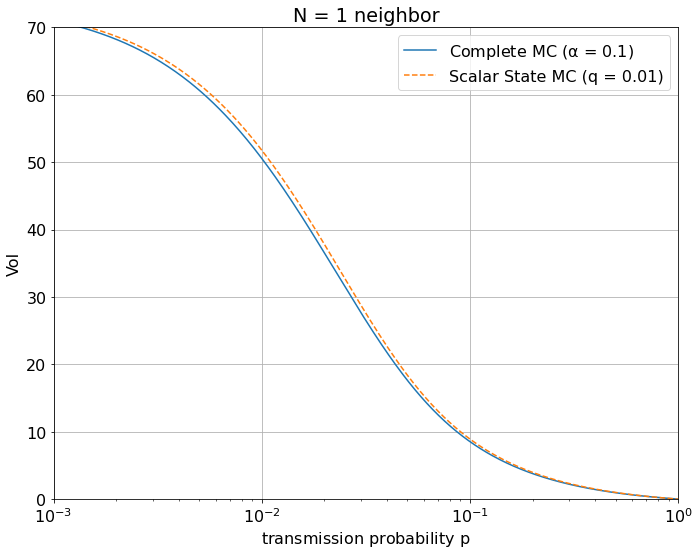

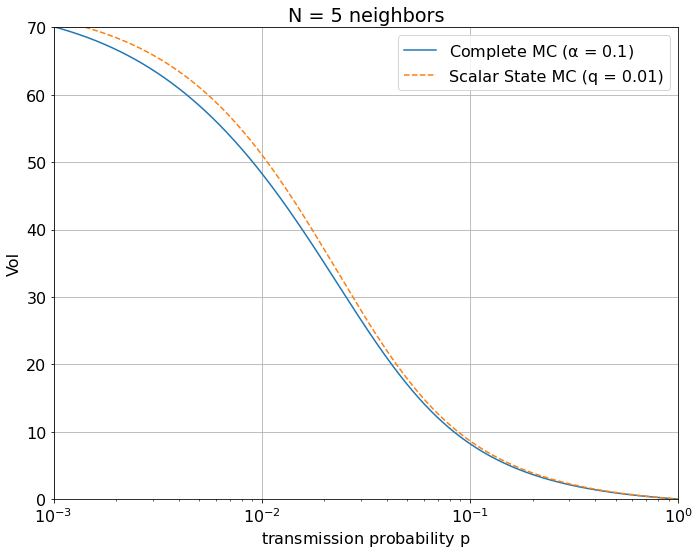

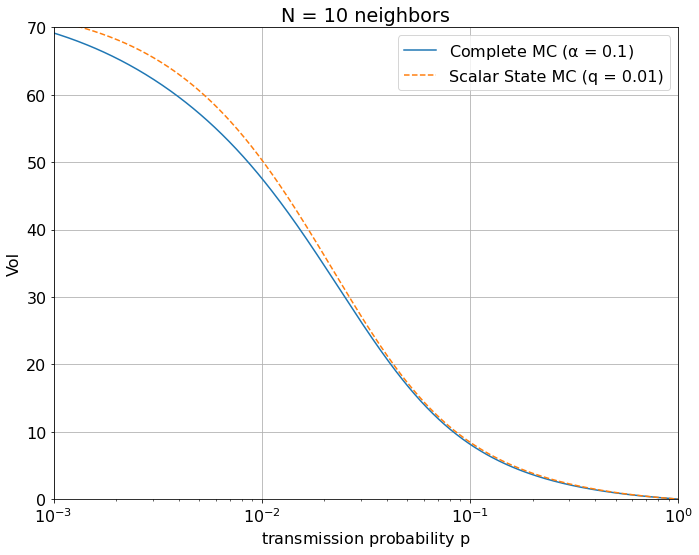

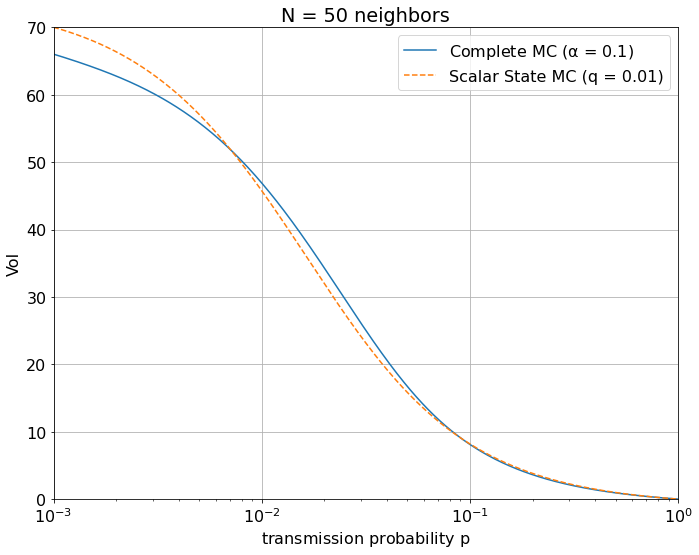

In [ ]:
c_vector = np.geomspace(1, 1000, len(p_tx_vector))
save_fig = True
linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']

# simple_MC_pi_vectors = np.load("/content/drive/MyDrive/Colab Notebooks/Saved Variables/simple_MC_q10.npy")
# complex_MC_pi_vectors = np.load("/content/drive/MyDrive/Colab Notebooks/Saved Variables/complex_MC.npy")
simple_MC_pi_vectors = np.asarray(simple_MC_vector_list)
complex_MC_pi_vectors = np.asarray(complex_MC_vector_list)

idx = 0
for i in range(2):
  for j in range(2):
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))

    average_aoi_vector_1 = average_aoi_matrix_1[idx]
    average_aoi_vector_2 = average_aoi_matrix_2[idx]
    
    ax.plot(p_tx_vector, average_aoi_vector_2)
    ax.plot(p_tx_vector, average_aoi_vector_1, linestyle = 'dashed')

    if(idx == 0): ax.set_title("N = " + str(N_vector[idx]) + " neighbor")
    else: ax.set_title("N = " + str(N_vector[idx]) + " neighbors")
    ax.grid(True)
    ax.legend([r"Complete MC $(\alpha$ = {})".format(alpha), "Scalar State MC (q = {})".format(q)])
    ax.set_xscale('log')
    ax.set_xlabel("transmission probability $p$")
    ax.set_xlim([1e-3, 1])
    ax.set_ylabel("VoI")
    ax.set_ylim([0, 70])

    params = {'mathtext.default': 'regular' }       
    plt.rcParams.update(params)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    
    if(save_fig):
      file_type = 'png'
      plt.savefig(r"MC_Comparison_VoI_given_ptx_q{}_alpha_{}_N_{}.".format(int(q * 100),int(alpha * 100), int(N_vector[idx])) + file_type, format=file_type)
      files.download(r"MC_Comparison_VoI_given_ptx_q{}_alpha_{}_N_{}.".format(int(q * 100),int(alpha * 100), int(N_vector[idx])) + file_type)
      file_type = 'eps'
      plt.savefig(r"MC_Comparison_VoI_given_ptx_q{}_alpha_{}_N_{}.".format(int(q * 100),int(alpha * 100), int(N_vector[idx])) + file_type, format=file_type)
      files.download(r"MC_Comparison_VoI_given_ptx_q{}_alpha_{}_N_{}.".format(int(q * 100),int(alpha * 100), int(N_vector[idx])) + file_type)

    idx += 1


## Confronto MC - VoI dato **c**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

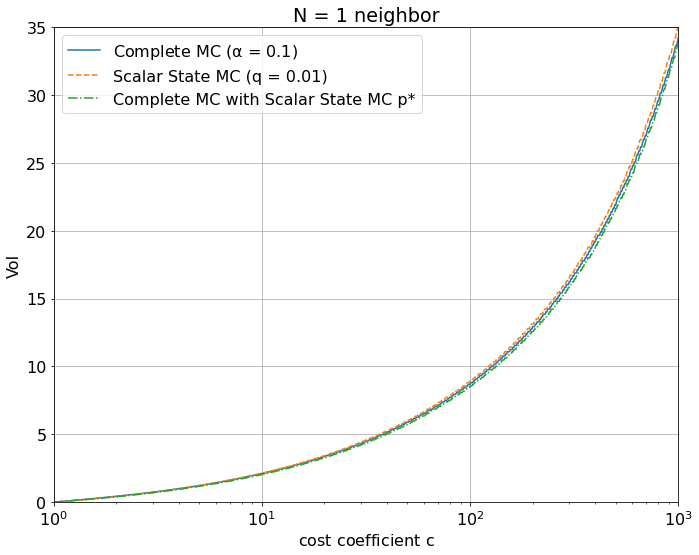

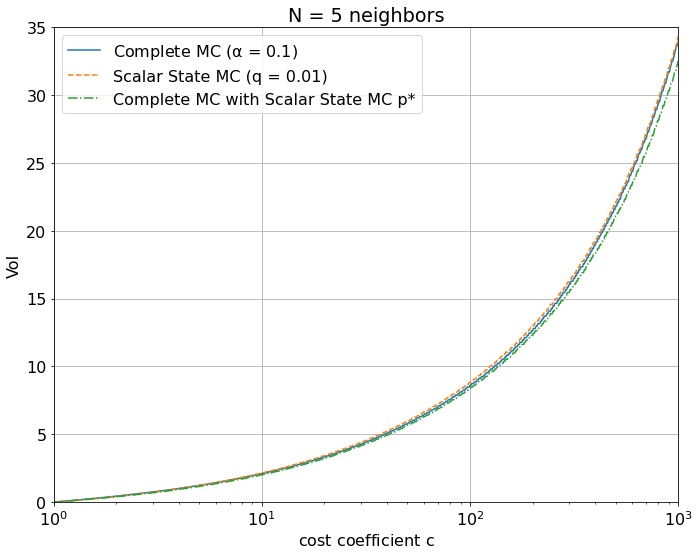

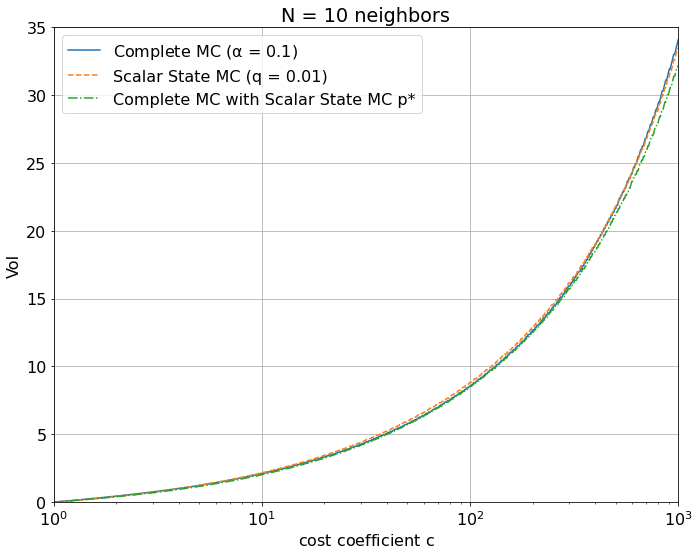

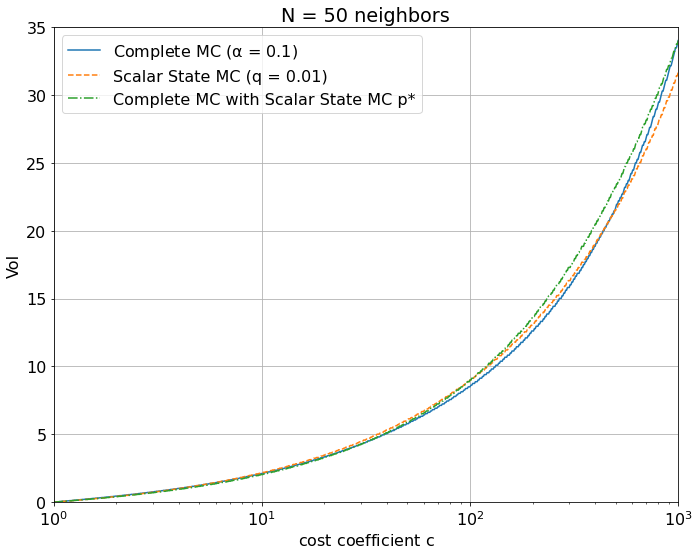

In [ ]:
c_vector = np.geomspace(1, 1000, len(p_tx_vector))
save_fig = True
linestyle_vector = ['solid', 'dotted', 'dashed', 'dashdot']

# simple_MC_pi_vectors = np.load("/content/drive/MyDrive/Colab Notebooks/Saved Variables/simple_MC_q10.npy")
# complex_MC_pi_vectors = np.load("/content/drive/MyDrive/Colab Notebooks/Saved Variables/complex_MC.npy")
simple_MC_pi_vectors = np.asarray(simple_MC_vector_list)
complex_MC_pi_vectors = np.asarray(complex_MC_vector_list)

idx = 0
for i in range(2):
  for j in range(2):
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))

    average_aoi_vector_1 = average_aoi_matrix_1[idx]
    average_aoi_vector_2 = average_aoi_matrix_2[idx]

    aoi_given_c = []
    voi_given_c_1 = []
    voi_given_c_2 = []
    voi_given_c_3 = []
    for c in c_vector:
      average_aoi_vector_2 = average_aoi_matrix_1[idx]
      tmp_idx = find_idx_p_given_c(c, average_aoi_vector_2, p_tx_vector)
      voi_given_c_1.append(average_aoi_vector_2[tmp_idx])
      voi_given_c_3.append(average_aoi_matrix_2[idx][tmp_idx])

      average_aoi_vector_2 = average_aoi_matrix_2[idx]
      tmp_idx = find_idx_p_given_c(c, average_aoi_vector_2, p_tx_vector)
      voi_given_c_2.append(average_aoi_vector_2[tmp_idx])
      
        
    
    ax.plot(c_vector, voi_given_c_2)
    ax.plot(c_vector, voi_given_c_1, linestyle = 'dashed')
    ax.plot(c_vector, voi_given_c_3, linestyle = 'dashdot')

    if(idx == 0): ax.set_title("N = " + str(N_vector[idx]) + " neighbor")
    else: ax.set_title("N = " + str(N_vector[idx]) + " neighbors")
    ax.grid(True)
    ax.legend([r"Complete MC $(\alpha$ = {})".format(alpha), "Scalar State MC (q = {})".format(q), "Complete MC with Scalar State MC p*"])
    ax.set_xscale('log')
    ax.set_xlabel("cost coefficient $c$")
    ax.set_xlim([1, 1e3])
    ax.set_ylabel("VoI")
    ax.set_ylim([0, 35])

    params = {'mathtext.default': 'regular' }       
    plt.rcParams.update(params)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    
    if(save_fig):
      file_type = 'png'
      plt.savefig(r"MC_Comparison_VoI_given_c_q{}_alpha_{}_N_{}.".format(int(q * 100),int(alpha * 100), int(N_vector[idx])) + file_type, format=file_type)
      files.download(r"MC_Comparison_VoI_given_c_q{}_alpha_{}_N_{}.".format(int(q * 100),int(alpha * 100), int(N_vector[idx])) + file_type)
      file_type = 'eps'
      plt.savefig(r"MC_Comparison_VoI_given_c_q{}_alpha_{}_N_{}.".format(int(q * 100),int(alpha * 100), int(N_vector[idx])) + file_type, format=file_type)
      files.download(r"MC_Comparison_VoI_given_c_q{}_alpha_{}_N_{}.".format(int(q * 100),int(alpha * 100), int(N_vector[idx])) + file_type)

    idx += 1


# Test IEEE MetroLivEnv 2022

## AoI and number of transmission

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

T = 10000

event_probability = 0.05
p_error_ml_vector = [0, 0.01, 0.05]

p_start = 1e-4
p_end = 0.5
p_tx_vector = np.geomspace(p_start, p_end, 100)
q = 0.05
N = 30

average_aoi_simple_matrix = np.zeros((len(p_error_ml_vector), len(p_tx_vector)))
average_aoi_ml_matrix = np.zeros((len(p_error_ml_vector), len(p_tx_vector)))
n_tx_given_p_simple_matrix = np.zeros((len(p_error_ml_vector), len(p_tx_vector)))
n_tx_given_p_ml_matrix = np.zeros((len(p_error_ml_vector), len(p_tx_vector)))


idx = 0
for p_error_ml in p_error_ml_vector:
    average_aoi_simple = []
    average_aoi_ml = []
    n_tx_given_p_simple = []
    n_tx_given_p_ml = []
    
    for p_tx in p_tx_vector:
        
        tot_aoi_simple = 0
        aoi_simple = 0
        aoi_threshold_simple = 20
        sensor_tx_simple = 0
        
        tot_aoi_ml = 0
        aoi_ml = 0
        aoi_threshold_ml = aoi_threshold_simple
        sensor_tx_ml = 0
        max_threshold = T + 1
        
        for i in range(T):
            skip_simple = False
            skip_ml = False
          
            # Increase AoI
            aoi_simple += 1
            aoi_ml += 1
          
            neighbors_help = random.random()
          
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            # Simple case
          
            # Check if AoI surpass threshold or simple transmit in random fashion
            if(aoi_simple > aoi_threshold_simple or random.random() < p_tx):
                aoi_simple = 0
                sensor_tx_simple += 1
                skip_simple = True
            
            # Consider neighbours
            if not skip_simple: # No transmission for the sensor
                if(neighbors_help < (1 - (1 - p_tx)**N) * q): 
                    aoi_simple = 0
            
            # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            # ML case
          
            # Check if AoI surpass threshold or simple transmit in random fashion
            if(aoi_ml > aoi_threshold_ml or random.random() < p_tx):
                aoi_ml = 0
                sensor_tx_ml += 1
                skip_ml = True
            
            # Consider neighbours
            if not skip_ml: # No transmission for the sensor
                if(neighbors_help < (1 - (1 - p_tx)**N) * q): 
                    aoi_ml = 0
          
            event = random.random()
          
            if(event < event_probability * (1 - p_error_ml)): # Rare event correctly classified
                if(aoi_threshold_ml > 2): 
                    aoi_threshold_ml = aoi_threshold_simple / 2
                    # print("reset", event, event_probability * (1 - p_error_ml))
            else:
                if(aoi_threshold_ml < max_threshold): aoi_threshold_ml += 1
            
            tot_aoi_simple += aoi_simple
            tot_aoi_ml += aoi_ml
            
        # print("Total steps: ", i)
        # print("N tx simple = {}".format(sensor_tx_simple))
        # print("N tx ML     = {}".format(sensor_tx_ml))
        average_aoi_simple.append(tot_aoi_simple/T)
        average_aoi_ml.append(tot_aoi_ml/T)

        n_tx_given_p_simple.append(sensor_tx_simple)
        n_tx_given_p_ml.append(sensor_tx_ml)
        
        
    average_aoi_simple_matrix[idx, :] = np.asarray(average_aoi_simple)
    average_aoi_ml_matrix[idx, :] = np.asarray(average_aoi_ml)
    n_tx_given_p_simple_matrix[idx, :] = np.asarray(n_tx_given_p_simple)
    n_tx_given_p_ml_matrix[idx, :] = np.asarray(n_tx_given_p_ml)
    idx += 1



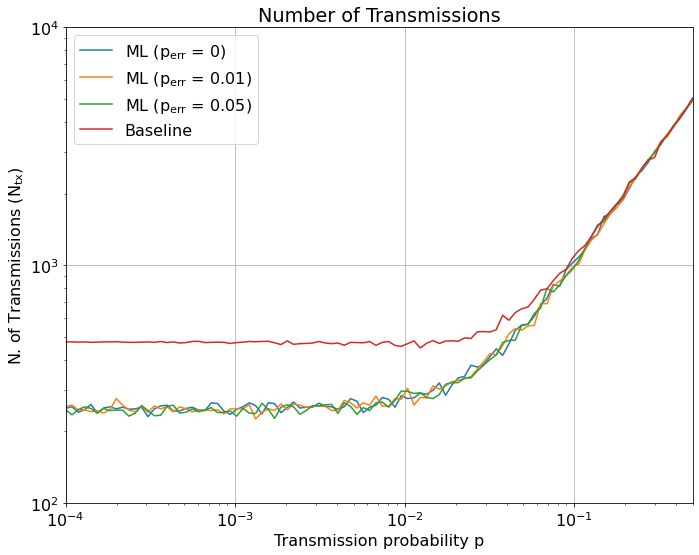

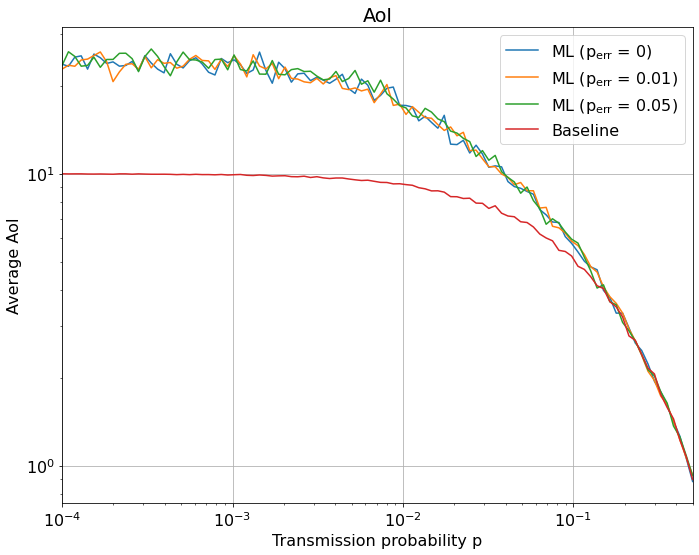

In [ ]:
plt.figure(figsize = (10, 8))
for i in range(len(p_error_ml_vector)): plt.plot(p_tx_vector, n_tx_given_p_ml_matrix[i])
plt.plot(p_tx_vector, n_tx_given_p_simple_matrix[0])
plt.xlabel("Transmission probability p")
plt.ylabel("N. of Transmissions ($N_{tx}$)")
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.title("Number of Transmissions")
plt.xlim([p_start, p_end])
plt.ylim([1e2, 1e4])
str_legend = ["ML ($p_{err}$ = " + str(i) + ")" for i in p_error_ml_vector]
str_legend.append("Baseline")
plt.legend(str_legend)
params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
# file_type = 'png'
# plt.savefig("ML_n_tx." + file_type, format=file_type)
# files.download("ML_n_tx." + file_type) 
# file_type = 'eps'
# plt.savefig("ML_n_tx." + file_type, format=file_type)
# files.download("ML_n_tx." + file_type) 

plt.figure(figsize = (10, 8))
for i in range(len(p_error_ml_vector)): plt.plot(p_tx_vector, average_aoi_ml_matrix[i])
plt.plot(p_tx_vector, average_aoi_simple_matrix[0])
plt.xlabel("Transmission probability p")
plt.ylabel("Average AoI")
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.title("AoI")
plt.xlim([p_start, p_end])
str_legend = ["ML ($p_{err}$ = " + str(i) + ")" for i in p_error_ml_vector]
str_legend.append("Baseline")
plt.legend(str_legend)
params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
# file_type = 'png'
# plt.savefig("ML_AoI." + file_type, format=file_type)
# files.download("ML_AoI." + file_type) 
# file_type = 'eps'
# plt.savefig("ML_AoI." + file_type, format=file_type)
# files.download("ML_AoI." + file_type)